In [16]:
from potes1DCNN import heartnet, reshape_folds
import tables
import matlab.engine
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
foldname='fold0'
load_path='/media/taufiq/Data/heart_sound/models/fold0 2017-12-20 16:10:31.624027/weights.0189-0.7399.hdf5'

## Import Model

In [3]:
random_seed=1
batch_size=64
fold_dir='/media/taufiq/Data/heart_sound/feature/potes_1DCNN/balancedCV/folds/'
log_dir= '/media/taufiq/Data/heart_sound/Heart_Sound/codes/logs/'
bn_momentum = 0.99
eps= 1.1e-5
bias=False
l2_reg=0.
l2_reg_dense=0.
kernel_size=5
maxnorm=10000.
dropout_rate=0.5
dropout_rate_dense=0.
padding='valid'
activation_function='relu'
subsam=2

lr=0.0007
lr_decay=1e-8

model = heartnet(activation_function,bn_momentum,bias,dropout_rate,dropout_rate_dense,
		eps,kernel_size,l2_reg,l2_reg_dense,load_path,lr,lr_decay,maxnorm,
		padding,random_seed,subsam)


## Import Data

In [4]:
feat = tables.open_file(fold_dir+foldname+'.mat')
x_val = feat.root.valX[:]
y_val = feat.root.valY[0,:]
val_parts = feat.root.val_parts[0,:]
y_qual = feat.root.valY[1,:]

for i in range(y_val.shape[0]):
	if y_val[i]==-1:
		y_val[i]=0
		
_,y_qual,x_val,y_val=reshape_folds(np.random.randn(4,4,4),x_val,y_qual,y_val)
print 'loading complete'

/home/taufiq/.local/lib/python2.7/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/valX`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


(4, 4, 1)
(7324, 1)
(7324, 2500, 1)
(7324, 1)
loading complete


In [5]:
y_pred=model.predict(x_val)
print y_pred

[[ 0.898862  ]
 [ 0.95630455]
 [ 0.95059872]
 ..., 
 [ 0.79589355]
 [ 0.79884112]
 [ 0.21087128]]


In [6]:
true = []
pred=[]
qual=[]
start_idx = 0
print val_parts.shape
for s in val_parts:	
	
	if s==0:		## for e1,32,39,44 in validation0 there was no cardiac cycle
		continue 
	#~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)
					
	temp_ = np.mean(y_val[start_idx:start_idx+int(s)-1])
	temp = np.mean(y_pred[start_idx:start_idx+int(s)-1,:])
	qual_ = np.mean(y_qual[start_idx:start_idx+int(s)-1,:])
	
	pred.append(temp)
	true.append(temp_)
	qual.append(qual_)
	
	start_idx = start_idx + int(s)		

true=np.array(true)
pred=np.array(pred)
qual=np.array(qual)

(301,)


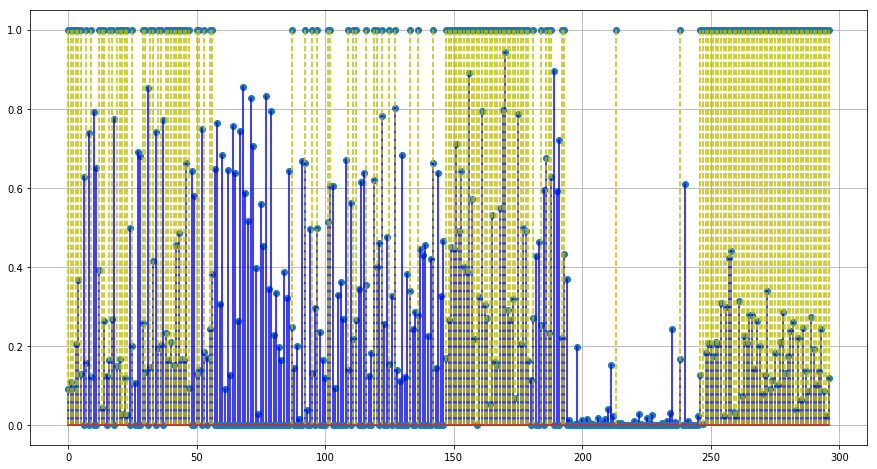

In [20]:
mpl.rcParams['figure.figsize']=(15,8)
plt.stem(range(0,true.shape[0]),((true-pred)**2)**.5,'b-')
plt.stem(range(0,true.shape[0]),true,'y--',linewidth=.002)
plt.grid()
plt.show()